<a href="https://colab.research.google.com/github/ybchen97/filler_detection/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

Syncing from google drive and github... for more info on this code, refer [here](https://zerowithdot.com/colab-github-workflow/)

In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive

drive.mount(ROOT)           # we mount the drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
GIT_PATH = "https://github.com/ybchen97/filler_detection.git"
!mkdir ./temp
!git clone "{GIT_PATH}"
!mv ./temp/* "{PROJECT_PATH}"
!rm -rf ./temp

Cloning into 'filler_detection'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 4967 (delta 46), reused 36 (delta 19), pack-reused 4887
Receiving objects: 100% (4967/4967), 841.51 MiB | 37.00 MiB/s, done.
Resolving deltas: 100% (492/492), done.
mv: cannot stat './temp/*': No such file or directory


Install packages in this local notebook specified in requirements.txt

In [4]:
!pip install -r '/content/filler_detection/requirements.txt'

     |████████████████████████████████| 194kB 9.8MB/s 
     |████████████████████████████████| 122kB 48.9MB/s 
     |████████████████████████████████| 163kB 44.6MB/s 
     |████████████████████████████████| 573kB 49.6MB/s 
     |████████████████████████████████| 9.5MB 42.8MB/s 
     |████████████████████████████████| 839kB 48.5MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 2.7MB 41.7MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 122kB 47.3MB/s 
     |████████████████████████████████| 788kB 43.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 1.1MB 34.4MB/s 
     |████████████████████████████████| 133kB 45.9MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 92kB 6.9MB/s 
    

Importing and setting up env variables...

In [0]:
import numpy as np
np.random.seed(1337) # for reproducibility
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
from tf_utils import *
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import pickle

# Import files for trigger-word detection model
import keras.backend as K
import tensorflow as tf
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, ConvLSTM2D
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping
from sklearn.utils import class_weight

In [0]:
PROJ_PATH = '/content/drive/My Drive/filler_detection/'

### Create New Model (if not pre-trained)

Sanity check for `Tx`, `n_freq`, `Ty`. 

1. Input into model `Tx` and `n_freq`
2. Call `model.summary()`
3. `Tx` of **sample** and variable = `input_7.shape[1]` (ie column 2, row 1, second element of array)
4. `Ty` = `input_7.shape[1]` (ie column 2, row 2, second element of array)

In [0]:
Tx = 5490 # The number of time steps input to the model from the spectrogram
n_freq = 129 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1369 # The number of time steps in the output of our model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_gru(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 2: First GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second GRU Layer
    # GRU (use 128 units to return the sequences)
    X = GRU(units=128, return_sequences=True)(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_lstm(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV Layer
    # CONV-1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch Normalization
    X = BatchNormalization()(X)
    # RelU activation
    X = Activation("relu")(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 2: First bi-lstm Layer
    # bi-lsem (use 128 units to return the sequences)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second bi-lstm Layer
    # lstm (use 128 units to return the sequences)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
from keras.initializers import RandomNormal

# GRADED FUNCTION: model

def create_convlstm2d(input_shape, output_bias=None, dropout=0.8):
    """
    Function creating the model's graph in Keras library.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    print(X_input)
    
    # Step 2: First bi-lstm Layer
    # bi-lsem (use 128 units to return the sequences)
    X = Bidirectional(ConvLSTM2D(filters=196, kernel_size=(15, 1), strides=4, return_sequences=True))(X_input)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    
    # Step 3: Second bi-lstm Layer
    # lstm (use 128 units to return the sequences)
    X = Bidirectional(ConvLSTM2D(filters=196, kernel_size=(1, 1), strides=1, return_sequences=True))(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    # Batch Normalization
    X = BatchNormalization()(X)
    # Dropout (using rate 0.8)
    X = Dropout(rate=dropout)(X)
    
    # Step 4: Time-distributed dense layer
    if output_bias != None: 
        bias_initializer = RandomNormal(mean=output_bias) 
    else: 
        bias_initializer = "zeros"
    X = TimeDistributed(Dense(1, activation="sigmoid", bias_initializer= bias_initializer))(X)
    X = Reshape((Ty, 1))(X)
    
    # Return model
    model = Model(inputs = [X_input], outputs = X)
    return model

In [0]:
model = create_lstm(input_shape = (Tx, n_freq), output_bias = None)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_19 (Batc (None, 1369, 196)         784       
_________________________________________________________________
activation_7 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1369, 196)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1369, 256)         332800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1369, 256)         0   

In [16]:
model = create_convlstm2d(input_shape = (None, Tx, 1, n_freq))
model.summary()

Tensor("input_6:0", shape=(None, None, 5490, 1, 129), dtype=float32)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, 5490, 1, 129 0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 1369, 1, 392 7645568   
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 1369, 1, 392 0         
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 1369, 1, 392 1568      
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 1369, 1, 392 923552    
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 1369, 1, 392 0         
________________________________________________________

### Load Weights of Pre-trained Model
Loaded weights instead of model due to custom metrics causing error in loading model directly. Read more [here](https://github.com/keras-team/keras/issues/10104).

In [0]:
model.load_weights(PROJ_PATH + "models/bryan_val_syn.h5") 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5490, 129)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1369, 196)         379456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1369, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1369, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1369, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1369, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1369, 128)         0   

## Model Training

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
import keras

# Function to fit and further train the model. Returns history (check documentation of `model.fit` for more details).
def model_train(model, X, Y, X_dev, Y_dev):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """

    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
    ]

    es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.05, 
                                            patience=100, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True)

    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss=f1_loss, optimizer=opt, metrics=METRICS)
    
    history = model.fit(X, Y, batch_size=50, epochs=100, validation_data=(X_dev, Y_dev), callbacks = [es])
    return history

In [0]:
X = np.load(PROJ_PATH + "data/train/bryan/X.npy")
Y = np.load(PROJ_PATH + "data/train/bryan/Y.npy")
print("X: {} Y: {}".format(X.shape, Y.shape))

X: (1009, 5490, 129) Y: (1009, 1369, 1)


In [0]:
X_dev = np.load(PROJ_PATH + "data/dev_synthesised/bryan/X_dev.npy")
Y_dev = np.load(PROJ_PATH + "data/dev_synthesised/bryan/Y_dev.npy")
print("X: {} Y: {}".format(X_dev.shape, Y_dev.shape))

X: (177, 5490, 129) Y: (177, 1369, 1)


In [0]:
model_filename = "bryan_val_syn_es"
history_filename = "bryan_val_syn_es"

history = model_train(model, X, Y, X_dev, Y_dev)

# Save model
model.save(PROJ_PATH + f"models/{model_filename}.h5")
print("model saved!")

# Save history
with open(PROJ_PATH + f'models/history/{history_filename}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("history saved!")

Train on 1009 samples, validate on 177 samples
Epoch 1/100
1009/1009 [==============================] - 91s 91ms/step - loss: 0.8884 - tp: 48100.0000 - fp: 692164.0000 - tn: 611814.0000 - fn: 29243.0000 - accuracy: 0.4777 - precision: 0.0650 - recall: 0.6219 - auc: 0.5612 - val_loss: 0.8679 - val_tp: 8192.0000 - val_fp: 98495.0000 - val_tn: 130447.0000 - val_fn: 5179.0000 - val_accuracy: 0.5721 - val_precision: 0.0768 - val_recall: 0.6127 - val_auc: 0.6036
Epoch 2/100


KeyboardInterrupt: ignored

## Model Evaluation Tools
1. Metrics (accuracy, f1, precision, recall). 
2. Visualising model's prediction
3. Visualising `Y.npy` to know where the ones are inserted.
4. Plot of metrics against epochs

In [0]:
X_test = np.load(PROJ_PATH + "data/test/bryan_synthesised/X_test.npy")
Y_test = np.load(PROJ_PATH + "data/test/bryan_synthesised/Y_test.npy")
print("X: {} Y: {}".format(X_test.shape, Y_test.shape))

X: (111, 5490, 129) Y: (111, 1369, 1)


### Plot of metrics against epochs

In [0]:
def plot_history(history):

    fig, axs = plt.subplots(2,3)
    fig.set_size_inches(15,7.5,forward=True)
    fig.tight_layout(pad=3.0)

    # Plot training & validation accuracy values
    axs[0,0].plot(history['accuracy'])
    axs[0,0].plot(history['val_accuracy'])
    axs[0,0].set_title('Model accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    axs[0,1].plot(history['loss'])
    axs[0,1].plot(history['val_loss'])
    axs[0,1].set_title('Model loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].legend(['Train', 'Val'], loc='upper right')

    # Plot precision loss values
    axs[1,0].plot(history['precision'])
    axs[1,0].plot(history['val_precision'])
    axs[1,0].set_title('Model Precision')
    axs[1,0].set_ylabel('Precision')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].legend(['Train', 'Val'], loc='upper left')

    # Plot recall loss values
    axs[1,1].plot(history['recall'])
    axs[1,1].plot(history['val_recall'])
    axs[1,1].set_title('Model Recall')
    axs[1,1].set_ylabel('Recall')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].legend(['Train', 'Val'], loc='upper right')

    axs[0,2].plot(history['auc'])
    axs[0,2].plot(history['val_auc'])
    axs[0,2].set_title('Model AUC')
    axs[0,2].set_ylabel('AUC')
    axs[0,2].set_xlabel('Epoch')
    axs[0,2].legend(['Train', 'Val'], loc='upper right')

    axs[1,2].set_visible(not axs[1,2].get_visible())

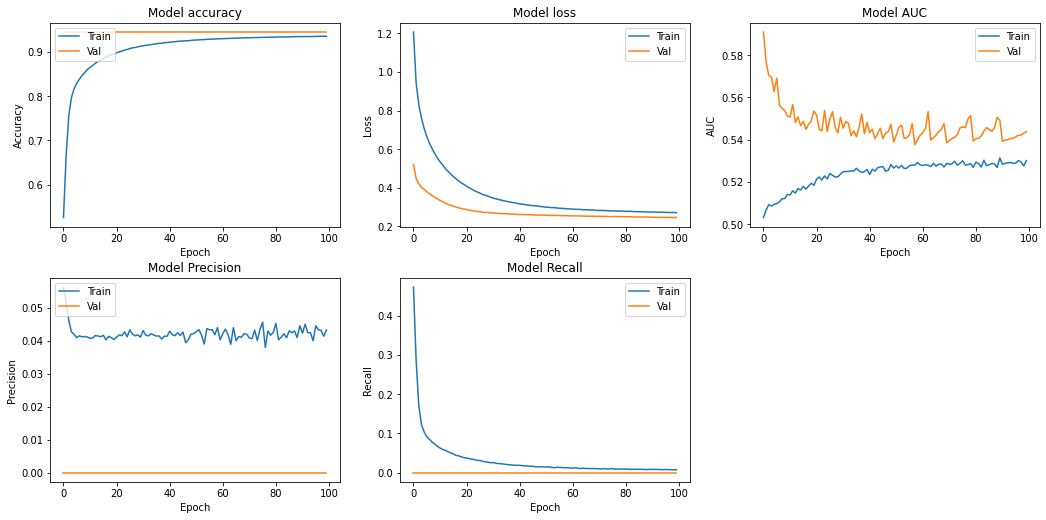

In [0]:
# Load history CHANGE HISTORY PATH HERE
history_filename = "bryan_val_syn"
history = pickle.load(open(PROJ_PATH +f'models/history/{history_filename}', "rb"))
plot_history(history)

### Outputs accuracy, F1 score, precision, recall scores

In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# Evaluates the model on the test sets based on accuracy, precision, recall, and f1 score.
def evaluate_model(model, X_test, Y_test, threshold=0.5):
    # predict probabilities for dev set
    Y_predict = model.predict(X_test, verbose=0)
    # Applying sigmoid onto prediction of probabilities in order to use f-score
    Y_predict = np.where(Y_predict > 0.3, 1, 0)

    # flatten array in order to use fscore
    Y_test_flattened = Y_test.flatten()
    Y_predict_flattened = Y_predict.flatten()

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(Y_test_flattened, Y_predict_flattened)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(Y_test_flattened, Y_predict_flattened)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(Y_test_flattened, Y_predict_flattened)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(Y_test_flattened, Y_predict_flattened)
    print('F1 score: %f' % f1)

Plots model's prediction for each `Ty` step for the `%index` example

In [0]:
# visualises model's prediction on the %index example of training input X.
def visualize_prediction(model, X, index=0):
    Y_predict = model.predict(X, verbose=0)

    plt.subplot(2, 1, 2)
    plt.plot(Y_predict[index,:,0])
    plt.ylabel('probability')
    plt.show()

Plots `Ty` for the `%index` example

In [0]:
def plot_Y(Y, index=0):
    plt.plot(Y[index])

In [0]:
evaluate_model(model, X_test, Y_test)

Accuracy: 0.947071
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


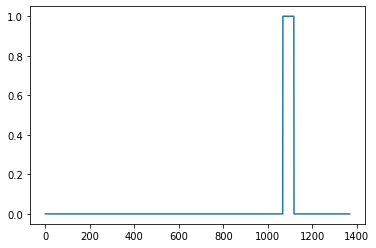

In [0]:
plot_Y(Y_test, 2)

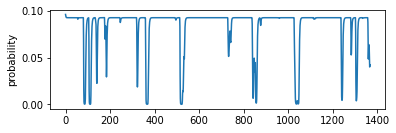

In [0]:
visualize_prediction(model, X_test, 2)

## Saving the model

In [0]:
model.save(PROJ_PATH + "models/please_save_me.h5")

## [Doesn't work] Confirming that the bias fix helps


In [0]:
zero_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = None)
model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 109s 1s/step - loss: 1.0449 - val_loss: 0.6329


In [0]:
careful_bias_model = create_model(input_shape = (Tx, n_freq), output_bias = initial_bias)
model_train(model, X, Y, X_dev, Y_dev)

Train on 100 samples, validate on 50 samples
Epoch 1/1
100/100 [==============================] - 106s 1s/step - loss: 0.9929 - val_loss: 0.6188


In [0]:
evaluate_model(zero_bias_model, X_test, Y_test, 0.3)
evaluate_model(careful_bias_model, X_test, Y_test, 0.3)

Accuracy: 0.256947
Precision: 0.036460
Recall: 0.777778
F1 score: 0.069654
Accuracy: 0.964237
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
visualize_prediction(model, X_test)

NameError: ignored

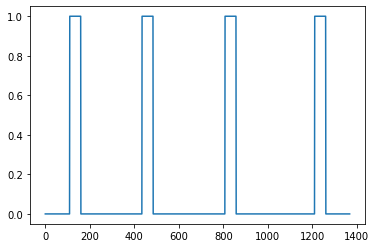

In [0]:
plt.plot(Y_test[0]) # TODO: add into evaluation tools

In [0]:
evaluate_model(model, X_test, Y_test, 0.5)

Accuracy: 0.289730
Precision: 0.166278
Recall: 0.962681
F1 score: 0.283575


Notice how there is only one sharp peak in the `careful_bias_model` but many sharp peaks in `zero_bias_model`

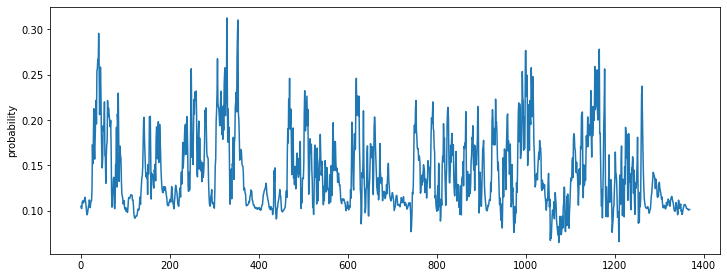

In [0]:
visualize_prediction(careful_bias_model, X_test)

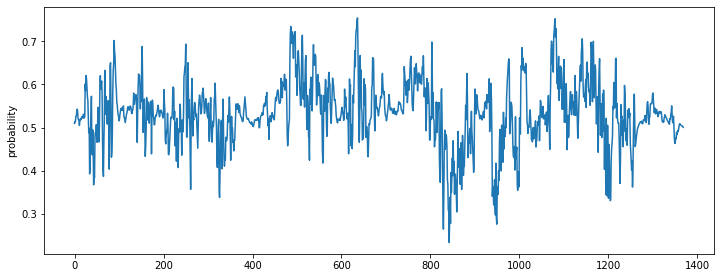

In [0]:
visualize_prediction(zero_bias_model, X_test)

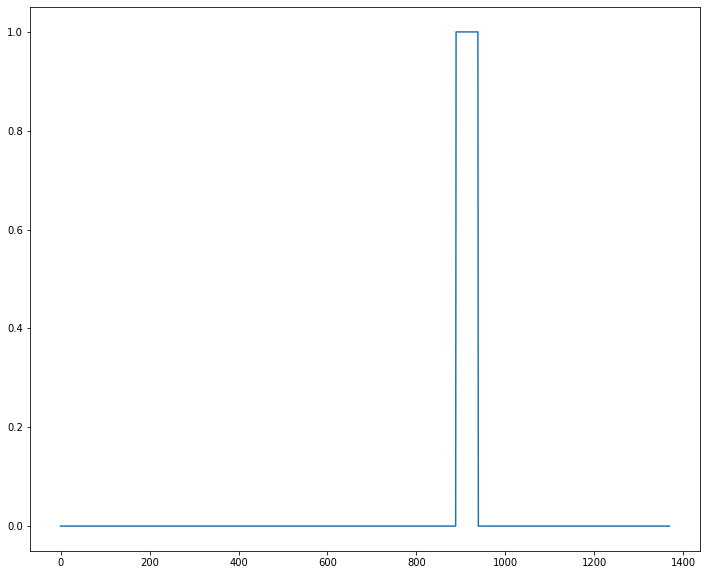

In [0]:
plt.plot(Y_test[0]) 

[Can delete the code below since `model.evaluate` is redundant now; it does not use metrics we want (ie f score)]

In [0]:
# For colab
# Function to test the model on new data
def model_test(model, X_dev, Y_dev):
    loss, acc = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

In [0]:
model_test(model, X_dev, Y_dev)

50/50 [==============================] - 8s 164ms/step
Dev set accuracy =  0.9633309245109558


In [0]:
X_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11X.npy")
Y_11 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_11Y.npy")
print("X: {} Y: {}".format(X_11.shape, Y_11.shape))

X_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12X.npy")
Y_12 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_12Y.npy")
print("X: {} Y: {}".format(X_12.shape, Y_12.shape))

X_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13X.npy")
Y_13 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_13Y.npy")
print("X: {} Y: {}".format(X_13.shape, Y_13.shape))

X_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14X.npy")
Y_14 = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_14Y.npy")
print("X: {} Y: {}".format(X_14.shape, Y_14.shape))








In [0]:
model_test(model, X_11, Y_11)
model_test(model, X_12, Y_12)
model_test(model, X_13, Y_13)
model_test(model, X_14, Y_14)

In [0]:
list_of_dev_ids = [11,12,13,14,20,21,22,23,24,30,31,32,33,34,35,36,37,38,39,310,40,41,42,43,44]
for id in list_of_dev_ids:
    X_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "X.npy")

    Y_id = np.load("/content/drive/My Drive/filler_detection/train_data/dev_npy/cont_" + str(id) + "Y.npy")
    print(("X" + str(id) + ": {} Y" + str(id) + ": {}").format(X_id.shape, Y_id.shape))
    model_test(model, X_id, Y_id)

model_test(model, X_11, Y_11)

## Hyperparameter Optimization

Redefine model train function to accept parameters...

In [0]:
import talos

# Function to fit and further train the model. Returns history (check documentation of `model.fit` for more details).
# This function is a special version being used for hyperparameter optimization.
def hyperparam_optimize(X, Y, X_dev, Y_dev, params):
    """
    Function to train the model further using Adam optimiser and binary 
    cross entropy loss.
    
    Arguments:
    model -- Model to train
    X -- X data to train on
    Y -- Y data to train on
    """
    
    model = create_model(input_shape = (Tx, n_freq), output_bias = None, dropout=params['dropout'])
    
    es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.05, 
                                            patience=15, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True)

    
    opt = Adam(lr=params['lr'], beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss=f1_loss, optimizer=opt)
    
    history = model.fit(X, Y, batch_size=25, epochs=40, validation_data=(X_dev, Y_dev), callbacks = [es])
    return history, model

Load params to use in Talos function...

In [0]:
params = {
    'lr': [0.001, 0.003, 0.005, 0.007, 0.009, 0.01],
    'dropout': [0.3, 0.4, 0.5, 0.6, 0.7]
}

Import Talos and use...

In [0]:
import talos

scan_object = talos.Scan(X, Y, 
                         x_val=X_dev, 
                         y_val=Y_dev, 
                         model=hyperparam_optimize, 
                         params=params, 
                         experiment_name='test')

model_name = 'bryan_concat_LSTM_dropout_04'

# Save object and model
scan_object.best_model(metric='val_loss', asc=True).save(PROJ_PATH + f"models/hyperparam_scan_data/{model_name}.h5")
with open(PROJ_PATH + f'models/hyperparam_scan_data/{model_name}.pkl', 'wb') as f:
    pickle.dump(scan_object.data, f)

Get Talos data after running hyperparameter optimization...

In [0]:
# Get data
with open(PROJ_PATH + f'models/hyperparam_scan_data/{model_name}.pkl', 'rb') as f:
    data = pickle.load(f)
data